# Introduction

[Jupyter](http://jupyter.org/) is an interactive browser based notebook environment where we can combine text, code execution and visualization. It supports multiple programming languages through it's language specific kernel plugins. However, it is widely used with Python in scientific computing and data science communities. The availability of large number of high quality open source libraries useful for many tasks in scientific computing,numerical linear algebra, machine learning and visualization ensures that Python is being widely used in these fields. Jupyter notebooks are an excellent environment for learning and teaching because of the interactivity.

In this short blogpost, I will explore few topics to illustrate the interactivity of the jupyter environment and the  availability of high quality libraries in the python ecosystem.
- Montecarlo calculation of $\pi$
- Image Compression using Singular value decomposition

# A note on installation of jupyter

Installation of jupyter and other important packages individually is cumbersome. Thanks to [Continuum Analytics](https://www.continuum.io/downloads) we have Anaconda python distribution in which almost all of the useful packages are bundled. Install anaconda.

   # Montecarlo calculation of $\pi$

I had earlier written about calculating the mathematical constant $\pi$ using [montecarlo method](https://medium.com/@rameshputalapattu/life-of-pi-a-gophers-tale-2e6922b80792). It involves generating random points on a unit square and counting the number of points inside the unit quarter circle. We will write a function ```mc_pi``` to calculate $\pi$. In that function, we will also visualize the process of montecarlo simulation using matplotlib library.

In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
#This line is required to display visualizations in the browser
%matplotlib inline

In [3]:
def mc_pi(ntrials):
    """
    calculate the value of pi using montecarlo method and visualize the process
    
    """
    x = np.random.random(ntrials)
    y = np.random.random(ntrials)
    #masking
    inside_circle = x**2+y**2 < 1
    unit_circle_x = np.linspace(0,1,100)
    unit_circle = [unit_circle_x,np.sqrt(1.0-unit_circle_x**2)]
    plt.plot(*unit_circle,color='black')
    plt.scatter(x[inside_circle],y[inside_circle],marker='.',color='blue',s=1)
    plt.scatter(x[~inside_circle],y[~inside_circle],marker='.',color='red',s=1)
    plt.title("value of $\pi$="+str( 4.0*np.sum(inside_circle)/float(ntrials)))
       

We are able to write the function ```mc_pi``` without making use of any explicit ```for``` loops - thanks to vectorization features in numpy library. Due to a concept called broadcasting in numpy, we are able to subtract a vector from a scalar (1.0 - unit_circle_x**2 ) to compute the y co-ordinate of the unit circle. 

Now we will make use of ipywidgets module to pass the parameter interactively to the function ```mc_pi```. ipywidgets module provide widgets to generate the UI controls in the notebook itself with which the user can interact. We can drag the slider and observe how the value of pi calculated by mc_pi function changes with the number of trials.

In [5]:
from ipywidgets import interact,interactive,interact_manual
mc_widget=interactive(mc_pi,ntrials=(1,100000,10));
mc_widget

interactive(children=(IntSlider(value=49991, description='ntrials', max=100000, min=1, step=10), Output()), _d…

### SVD and Image compression

Now we will explore how to apply Singular Value Decomposition of a matrix to the problem of image compression. SVD decomposes a rectangular matrix $M$ to a three parts.
$M=U\Sigma V^T$  -
- $U$ - matrix of left singular vectors in the columns
- $\Sigma$ - diagonal matrix with singular values
- $V$ - matrix of right singular vectors in the columns

SVD in effect involves reconstructing the original matrix as a linear combination of several rank one matrices. A rank one matrix can be expressed as a outer product of two column vectors. 

$M=\sigma_1u_1v_1^T+\sigma_2u_2v_2^T+\sigma_3u_3v_3^T+\sigma_3u_3v_3^T+....$ . 
A matrix of rank r will have r terms of these.

Here $\sigma_1,\sigma_2,\sigma_3 ...$ are singular values. $u_1,u_2,u_3 ...$ and $v_1,v_2,v_3 ...$ are left and right singular vectors respectively.

Image compression using SVD involves taking advantage of the fact that very few of the singular values are large. Although images from the real world are of full rank, they have low effective rank which means that only few of the singular values of the SVD of images will be large.

### skimage image processing library

We will use skimage image processing library (from sci-kit family of packages) for working with images in python. skimage has a module called data which makes available a set of images for exploration.  We will load some images and convert them into a gray scale format. These images are stored in a python dict object gray_images.

In [6]:
from skimage import data
from skimage.color import rgb2gray

In [7]:
from skimage import img_as_ubyte,img_as_float
gray_images = {
        "cat":rgb2gray(img_as_float(data.chelsea())),
        "astro":rgb2gray(img_as_float(data.astronaut())),
        "camera":data.camera(),
        "coin": data.coins(),
        "clock":data.clock(),
        "blobs":data.binary_blobs(),
        "coffee":rgb2gray(img_as_float(data.coffee()))
}

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/skimage/data/_binary_blobs.py:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[[indices for indices in points]] = 1


### svd in python
We will use ```numpy.linalg``` library's ```svd``` function to compute svd of a matrix in python. The svd function returns U,s,V .
   - U has left singular vectors in the columns
   - s is rank 1 numpy array with singular values
   - V has right singular vectors in the rows -equivalent to $V^T$ in traditional linear algebra literature
   
The reconstructed approximation of the original matrix is done using a subset of singular vectors as below in the ```compress_svd``` function . We use numpy array slicing to select k singular vectors and values.  Instead of storing $m\times n$ values for the original image, we can now store $k(m+n)+k$ values

           reconst_matrix = np.dot(U[:,:k],np.dot(np.diag(s[:k]),V[:k,:]))
           

In [8]:
from numpy.linalg import svd


In [9]:
def compress_svd(image,k):
    """
    Perform svd decomposition and truncated (using k singular values/vectors) reconstruction
    returns
    --------
      reconstructed matrix reconst_matrix, array of singular values s
    """
    U,s,V = svd(image,full_matrices=False)
    reconst_matrix = np.dot(U[:,:k],np.dot(np.diag(s[:k]),V[:k,:]))
   
    return reconst_matrix,s

### Compress gray scale images
The function ```compress_show_gray_images``` below takes in the image name (img_name) and number of singular values/vectors(k) to be used in the compressed reconstruction. It also plots the singular values and the image.

In [10]:
def compress_show_gray_images(img_name,k):
    """
     compresses gray scale images and display the reconstructed image.
     Also displays a plot of singular values
    """
    image=gray_images[img_name]
    original_shape = image.shape
    reconst_img,s = compress_svd(image,k)
    fig,axes = plt.subplots(1,2,figsize=(8,5))
    axes[0].plot(s)
    compression_ratio =100.0* (k*(original_shape[0] + original_shape[1])+k)/(original_shape[0]*original_shape[1])
    axes[1].set_title("compression ratio={:.2f}".format(compression_ratio)+"%")
    axes[1].imshow(reconst_img,cmap='gray')
    axes[1].axis('off')
    fig.tight_layout()
    
    
    

Use the below interactive widget to explore how the quality of the reconstructed image varies with $k$

In [11]:
interact(compress_show_gray_images,img_name=list(gray_images.keys()),k=(1,300));

interactive(children=(Dropdown(description='img_name', options=('cat', 'astro', 'camera', 'coin', 'clock', 'bl…

### Load color images

In [14]:
color_images = {
    "cat":img_as_float(data.chelsea()),
    "astro":img_as_float(data.astronaut()),
    "coffee":img_as_float(data.coffee())
    
}

### Compress color images

Color images are represented in python as 3 dimensional numpy arrays - the third dimension to represent the color values (red,green blue). However, svd method is applicable to two dimensional matrices. So we have to find a way to convert the 3 dimensional array to 2 dimensional arrays, apply svd and reconstruct it back as a 3 dimensional array . There are two ways to do it. We will show both these methods below .
   - reshape method
   - Layer method


#### Reshape method to compress a color image
This method involves flattening the third dimension of the image array into the second dimension using numpy's reshape method .
  
  ``` image_reshaped = image.reshape((original_shape[0],original_shape[1]*3))```

The svd decomposition is applied on the resulting reshaped array and reconstructed with the desired number of singular values/vectors. The image array is reshaped back to the three dimensions by another call to reshape method.
   
   ```image_reconst = image_reconst.reshape(original_shape)```



In [15]:
def compress_show_color_images_reshape(img_name,k):
    """
     compress and display the reconstructed color image using the reshape method 
    """
    image = color_images[img_name]
    original_shape = image.shape
    image_reshaped = image.reshape((original_shape[0],original_shape[1]*3))
    image_reconst,_ = compress_svd(image_reshaped,k)
    image_reconst = image_reconst.reshape(original_shape)
    compression_ratio =100.0* (k*(original_shape[0] + 3*original_shape[1])+k)/(original_shape[0]*original_shape[1]*original_shape[2])
    plt.title("compression ratio={:.2f}".format(compression_ratio)+"%")
    plt.imshow(image_reconst)

Here is the interactive widget to explore image compression of color images using the reshape method. By dragging the slider to vary $k$, observe how image quality varies. Also, we can explore different images by selecting through the drop down widget.

In [16]:
interact(compress_show_color_images_reshape,img_name=list(color_images.keys()),k=(0,512));

interactive(children=(Dropdown(description='img_name', options=('cat', 'astro', 'coffee'), value='cat'), IntSl…

### Layers method to compress color images
In the function ```compress_show_color_images_layer```, we treat a color image as a stack of 3 seperate two dimensional images  (Red,blue and green layers) . We apply the truncated svd reconstruction on each two dimensional layer seperately.

```image_reconst_layers = [compress_svd(image[:,:,i],k)[0] for i in range(3)]```

And we put back the reconstructed layers together.

```
image_reconst = np.zeros(image.shape)
for i in range(3):
   image_reconst[:,:,i] = image_reconst_layers[i]
```


   

In [20]:
def compress_show_color_images_layer(img_name,k):
    """
     compress and display the reconstructed color image using the layer method 
    """
    image = color_images[img_name]
    original_shape = image.shape
    image_reconst_layers = [compress_svd(image[:,:,i],k)[0] for i in range(3)]
    image_reconst = np.zeros(image.shape)
    for i in range(3):
        image_reconst[:,:,i] = image_reconst_layers[i]
    
    compression_ratio =100.0*3* (k*(original_shape[0] + original_shape[1])+k)/(original_shape[0]*original_shape[1]*original_shape[2])
    plt.title("compression ratio={:.2f}".format(compression_ratio)+"%")
    
    plt.imshow(image_reconst)

Here is the widget to explore layers method of compressing color images.

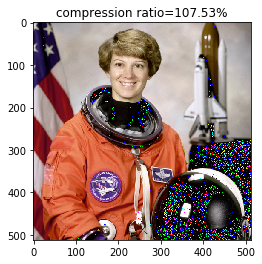

In [21]:
interact(compress_show_color_images_layer,img_name=list(color_images.keys()),k=(1,550));